# Energy Price Characteristics

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_optim
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import r2_score
from arch import arch_model
from scipy.stats import probplot, norm
import seaborn as sns
import statsmodels.api as sm

In [42]:
# Load data
datasets = {}
for hour in range(24): # 24
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}

In [43]:
dates_train = {hour: datasets[hour]['DATE'][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')] for hour in range(24)}
dates_train = pd.to_datetime(dates_train[0])

In [44]:
Y = np.mean(np.stack(list(y_train.values()), axis=0), axis=0).ravel() # daily average
Y_series = pd.Series(Y)

Y_diff = np.diff(Y)
Y_diff_series = pd.Series(Y_diff)
VAR_Y = (Y - Y.mean())**2
VAR_Y_diff = np.sqrt((Y_diff - Y_diff.mean())**2)


## Seasonality and Long Memory

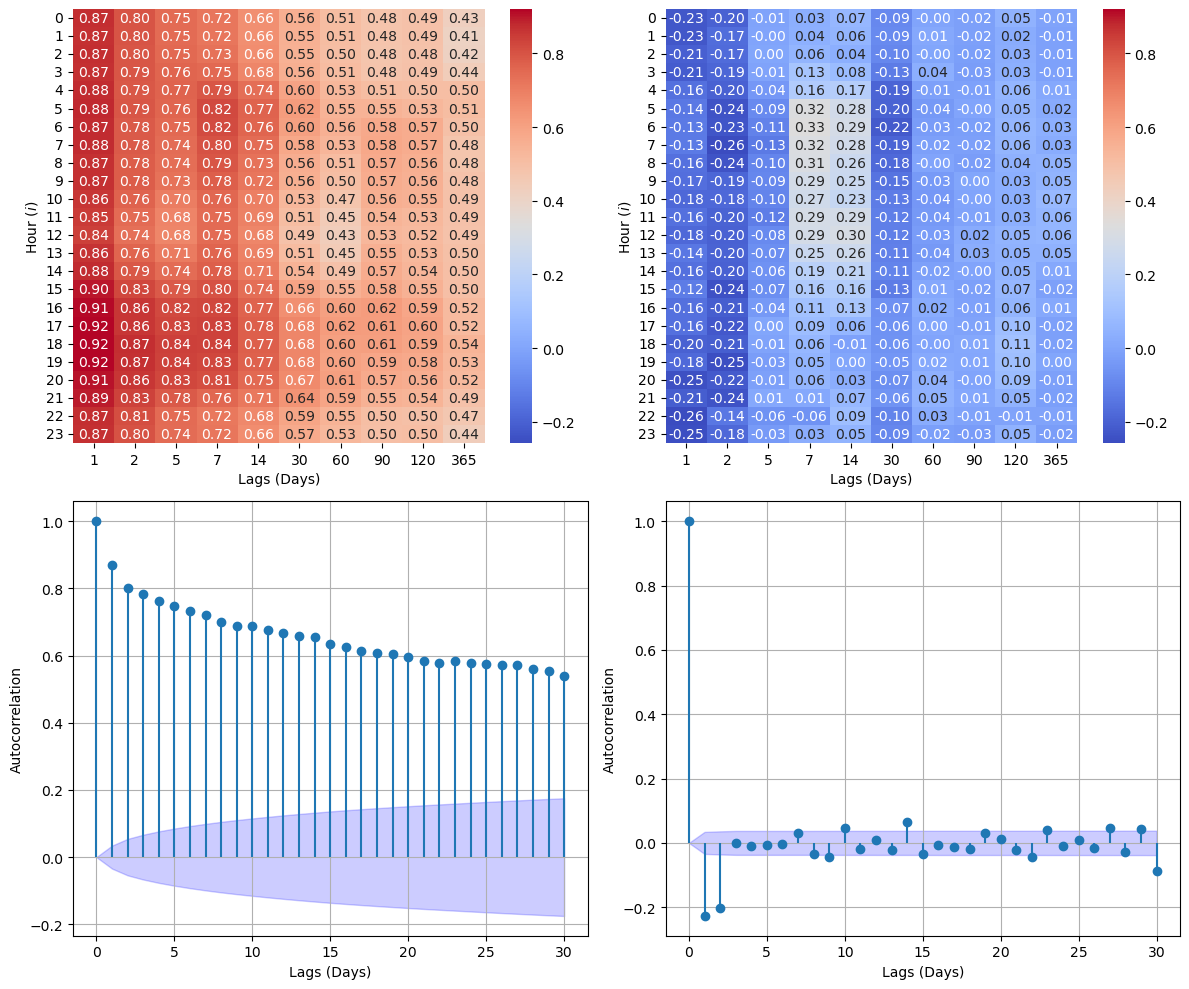

In [45]:
lags = [1, 2, 5, 7, 14, 30, 60, 90, 120, 365]
correlation_matrix = np.zeros((24, len(lags)))
diff_correlation_matrix = np.zeros((24, len(lags)))

# Compute the correlations for the original y_train
for i in range(24):
    y_series = pd.Series(y_train[i].ravel())
    for j, lag in enumerate(lags):
        lagged_series = y_series.shift(lag)
        correlation = y_series.corr(lagged_series)
        correlation_matrix[i, j] = correlation

# Compute the correlations for the differenced y_train
for i in range(24):
    y_diff_series = pd.Series(np.diff(y_train[i].ravel()))
    for j, lag in enumerate(lags):
        lagged_series = y_diff_series.shift(lag)
        correlation = y_diff_series.corr(lagged_series)
        diff_correlation_matrix[i, j] = correlation

# Determine the overall min and max values for normalization
overall_min = min(correlation_matrix.min(), diff_correlation_matrix.min())
overall_max = max(correlation_matrix.max(), diff_correlation_matrix.max())

# Create a 2 by 2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # figsize=(20, 16)
#figsize=(12, 4)

# Plot heatmaps
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", xticklabels=lags, yticklabels=range(24), cmap="coolwarm",
            vmin=overall_min, vmax=overall_max, ax=axes[0, 0])
#axes[0, 0].set_title(rf"Correlation Heatmap of $y_{{i,t}}$ and Lagged Values")
axes[0, 0].set_xlabel("Lags (Days)")
axes[0, 0].set_ylabel(rf"Hour $(i)$")

sns.heatmap(diff_correlation_matrix, annot=True, fmt=".2f", xticklabels=lags, yticklabels=range(24), cmap="coolwarm",
            vmin=overall_min, vmax=overall_max, ax=axes[0, 1])
#axes[0, 1].set_title(rf"Correlation Heatmap of $\Delta y_{{i,t}}$ and Lagged Values")
axes[0, 1].set_xlabel("Lags (Days)")
axes[0, 1].set_ylabel(rf"Hour $(i)$")

max_lag_acf = 30

# ACF for Y
y_series = pd.Series(y_train[0].ravel())
acf_Y, confint_Y = acf(y_series, nlags=max_lag_acf, alpha=0.05)
axes[1, 0].stem(range(len(acf_Y)), acf_Y, basefmt=" ")
axes[1, 0].fill_between(range(len(acf_Y)), confint_Y[:, 0] - acf_Y, confint_Y[:, 1] - acf_Y, color='blue', alpha=0.2)
#axes[1, 0].set_title("ACF of $Y_{t}$ with 95% Confidence Interval")
axes[1, 0].set_xlabel("Lags (Days)")
axes[1, 0].set_ylabel("Autocorrelation")
axes[1, 0].grid(True)

# ACF for differenced Y
y_diff_series = pd.Series(np.diff(y_train[0].ravel()))
acf_Y_diff, confint_Y_diff = acf(y_diff_series, nlags=max_lag_acf, alpha=0.05)
axes[1, 1].stem(range(len(acf_Y_diff)), acf_Y_diff, basefmt=" ")
axes[1, 1].fill_between(range(len(acf_Y_diff)), confint_Y_diff[:, 0] - acf_Y_diff, confint_Y_diff[:, 1] - acf_Y_diff, color='blue', alpha=0.2)
#axes[1, 1].set_title("ACF of $\Delta Y_{t}$ with 95% Confidence Interval")
axes[1, 1].set_xlabel("Lags (Days)")
axes[1, 1].set_ylabel("Autocorrelation")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

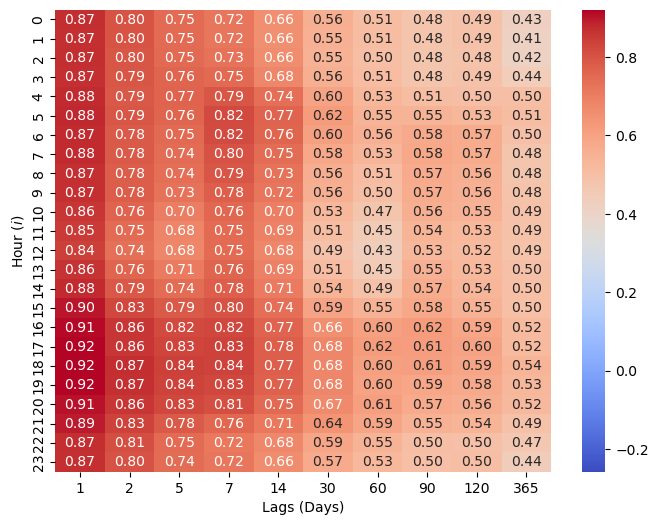

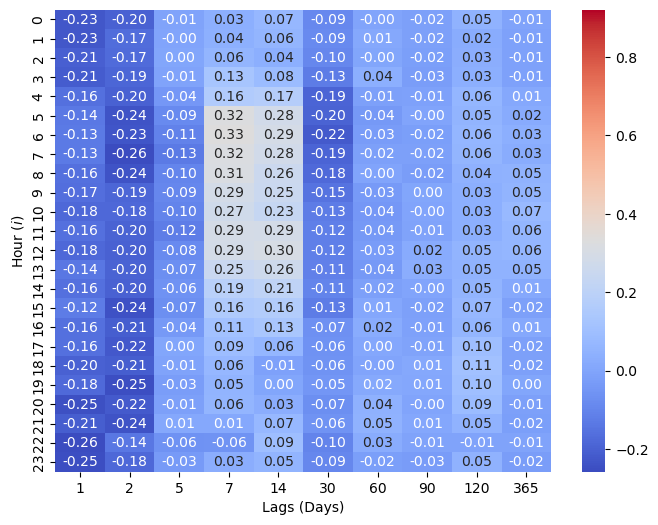

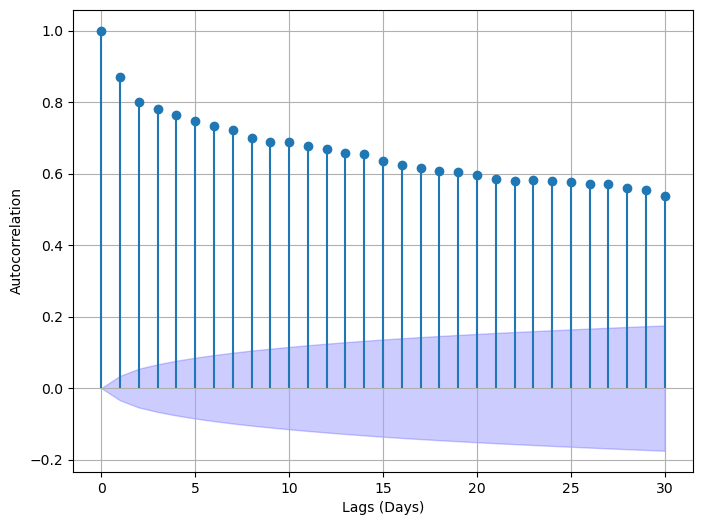

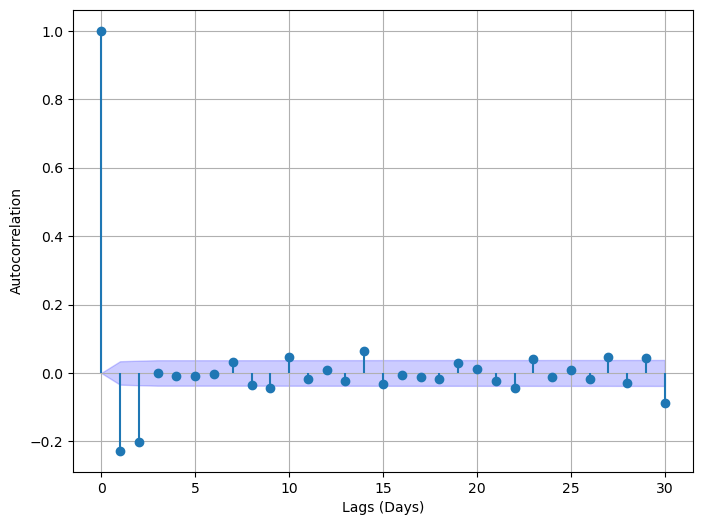

In [46]:
lags = [1, 2, 5, 7, 14, 30, 60, 90, 120, 365]
correlation_matrix = np.zeros((24, len(lags)))
diff_correlation_matrix = np.zeros((24, len(lags)))

# Compute the correlations for the original y_train
for i in range(24):
    y_series = pd.Series(y_train[i].ravel())
    for j, lag in enumerate(lags):
        lagged_series = y_series.shift(lag)
        correlation = y_series.corr(lagged_series)
        correlation_matrix[i, j] = correlation

# Compute the correlations for the differenced y_train
for i in range(24):
    y_diff_series = pd.Series(np.diff(y_train[i].ravel()))
    for j, lag in enumerate(lags):
        lagged_series = y_diff_series.shift(lag)
        correlation = y_diff_series.corr(lagged_series)
        diff_correlation_matrix[i, j] = correlation

# Determine the overall min and max values for normalization
overall_min = min(correlation_matrix.min(), diff_correlation_matrix.min())
overall_max = max(correlation_matrix.max(), diff_correlation_matrix.max())

# Plot 1: Heatmap for Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", xticklabels=lags, yticklabels=range(24), cmap="coolwarm",
            vmin=overall_min, vmax=overall_max)
plt.xlabel("Lags (Days)")
plt.ylabel(r"Hour $(i)$")
plt.show()

# Plot 2: Heatmap for Differenced Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(diff_correlation_matrix, annot=True, fmt=".2f", xticklabels=lags, yticklabels=range(24), cmap="coolwarm",
            vmin=overall_min, vmax=overall_max)
plt.xlabel("Lags (Days)")
plt.ylabel(r"Hour $(i)$")
plt.show()

# Plot 3: ACF for Original y_train
y_series = pd.Series(y_train[0].ravel())
acf_Y, confint_Y = acf(y_series, nlags=30, alpha=0.05)
plt.figure(figsize=(8, 6))
plt.stem(range(len(acf_Y)), acf_Y, basefmt=" ")
plt.fill_between(range(len(acf_Y)), confint_Y[:, 0] - acf_Y, confint_Y[:, 1] - acf_Y, color='blue', alpha=0.2)
plt.xlabel("Lags (Days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

# Plot 4: ACF for Differenced y_train
y_diff_series = pd.Series(np.diff(y_train[0].ravel()))
acf_Y_diff, confint_Y_diff = acf(y_diff_series, nlags=30, alpha=0.05)
plt.figure(figsize=(8, 6))
plt.stem(range(len(acf_Y_diff)), acf_Y_diff, basefmt=" ")
plt.fill_between(range(len(acf_Y_diff)), confint_Y_diff[:, 0] - acf_Y_diff, confint_Y_diff[:, 1] - acf_Y_diff, color='blue', alpha=0.2)
plt.xlabel("Lags (Days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

## Non-Stationarity and Mean-Reversion

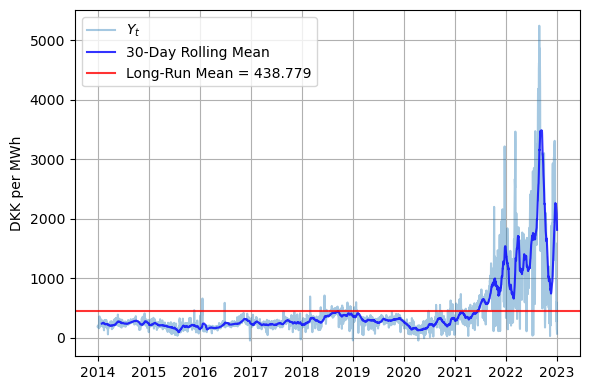

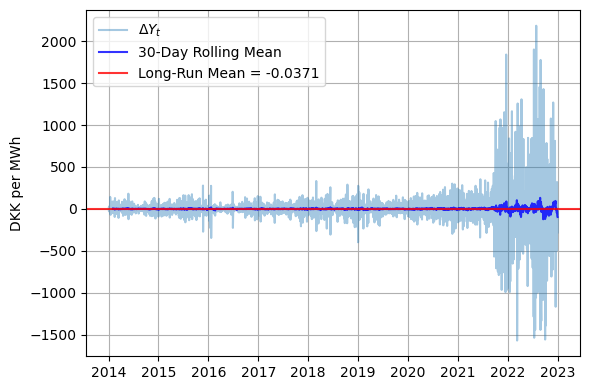

In [79]:
# Plot 1: Non-Stationarity of Y_t
plt.figure(figsize=(6, 4))
rolling_std = Y_diff_series.rolling(window=30).std()

#plt.title(rf'Non-Stationarity of $Y_t$')



rolling_window = 30
long_term_mean = Y.mean()
Y = pd.Series(Y, index=dates_train)
rolling_mean = Y.rolling(window=rolling_window).mean()
plt.plot(dates_train, Y, label=rf'$Y_t$', alpha=0.4)
plt.plot(dates_train, rolling_mean, color='b', label=rf'{rolling_window}-Day Rolling Mean', alpha=0.8)
plt.axhline(y=long_term_mean, color='r', alpha=0.8, label=rf'Long-Run Mean = {np.round(long_term_mean,4)}')

plt.grid(True)
plt.ylabel("DKK per MWh")

plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Time-Varying Mean-Reversion of ΔY_t
plt.figure(figsize=(6, 4))
rolling_window = 30
dates_diff = dates_train[1:]
long_term_mean = Y_diff.mean()
Y_diff_series = pd.Series(Y_diff, index=dates_diff)
rolling_mean = Y_diff_series.rolling(window=rolling_window).mean()

#plt.title(rf'Time-Varying Mean-Reversion of $\Delta Y_t$')
plt.plot(dates_diff, Y_diff_series, label=rf'$\Delta Y_t$', alpha=0.4)
plt.plot(dates_diff, rolling_mean, color='b', label=rf'{rolling_window}-Day Rolling Mean', alpha=0.8)
plt.axhline(y=long_term_mean, color='r', alpha=0.8, label=rf'Long-Run Mean = {np.round(long_term_mean,4)}')
plt.ylabel("DKK per MWh")
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


## Volatility-Conditional Mean

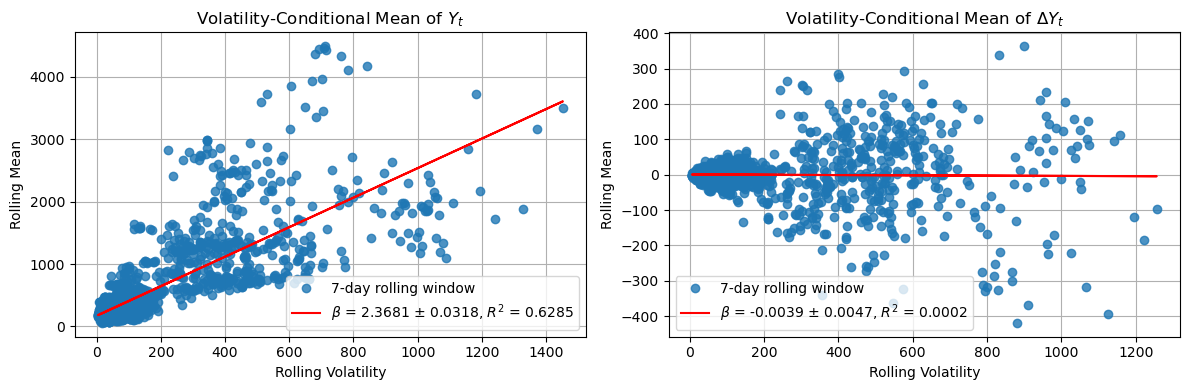

In [49]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

rolling_window = 7

# Function to calculate standard error of the slope
def compute_slope_std_err(x, y, slope, intercept):
    residuals = y - (slope * x + intercept)
    residual_sum_of_squares = np.sum(residuals ** 2)
    n = len(x)
    x_mean = np.mean(x)
    std_err_slope = np.sqrt(residual_sum_of_squares / (n - 2)) / np.sqrt(np.sum((x - x_mean) ** 2))
    return std_err_slope

## Plot 1 ##
rolling_mean = Y_series.rolling(window=rolling_window).mean()
rolling_volatility = Y_series.rolling(window=rolling_window).std()
valid_indices = ~np.isnan(rolling_mean) & ~np.isnan(rolling_volatility)
rolling_mean = rolling_mean[valid_indices]
rolling_volatility = rolling_volatility[valid_indices]

coefficients = np.polyfit(rolling_volatility, rolling_mean, 1)
slope, intercept = coefficients
linear_fit = np.poly1d(coefficients)
predicted_mean = linear_fit(rolling_volatility)
r2 = r2_score(rolling_mean, predicted_mean)

std_err_slope = compute_slope_std_err(rolling_volatility, rolling_mean, slope, intercept)

axes[0].plot(rolling_volatility, rolling_mean, 'o', alpha=0.8, label=rf'{rolling_window}-day rolling window')
axes[0].plot(rolling_volatility, predicted_mean, 'r-', 
             label=rf'$\beta$ = {slope:.4f} ± {std_err_slope:.4f}, $R^2$ = {r2:.4f}')
axes[0].set_xlabel('Rolling Volatility')
axes[0].set_ylabel('Rolling Mean')
axes[0].set_title(f'Volatility-Conditional Mean of $Y_t$')
axes[0].legend()
axes[0].grid(True)


## Plot 2 ##
rolling_mean_diff = Y_diff_series.rolling(window=rolling_window).mean()
rolling_volatility_diff = Y_diff_series.rolling(window=rolling_window).std()
valid_indices = ~np.isnan(rolling_mean_diff) & ~np.isnan(rolling_volatility_diff)
rolling_mean_diff = rolling_mean_diff[valid_indices]
rolling_volatility_diff = rolling_volatility_diff[valid_indices]

coefficients = np.polyfit(rolling_volatility_diff, rolling_mean_diff, 1)
slope, intercept = coefficients
linear_fit = np.poly1d(coefficients)
predicted_mean_diff = linear_fit(rolling_volatility_diff)
r2 = r2_score(rolling_mean_diff, predicted_mean_diff)

std_err_slope_diff = compute_slope_std_err(rolling_volatility_diff, rolling_mean_diff, slope, intercept)

axes[1].plot(rolling_volatility_diff, rolling_mean_diff, 'o', alpha=0.8, label=rf'{rolling_window}-day rolling window')
axes[1].plot(rolling_volatility_diff, predicted_mean_diff, 'r-', 
             label=rf'$\beta$ = {slope:.4f} ± {std_err_slope_diff:.4f}, $R^2$ = {r2:.4f}')
axes[1].set_xlabel('Rolling Volatility')
axes[1].set_ylabel('Rolling Mean')
axes[1].set_title(f'Volatility-Conditional Mean of $\Delta Y_t$')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

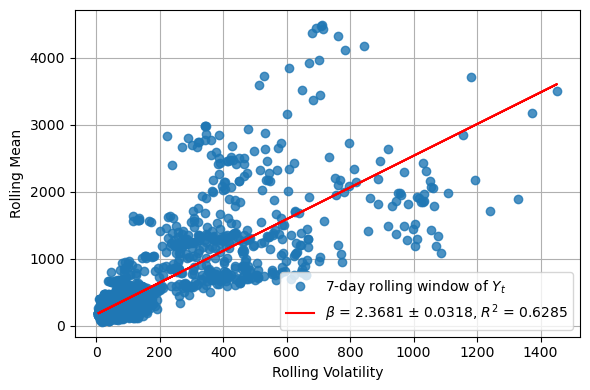

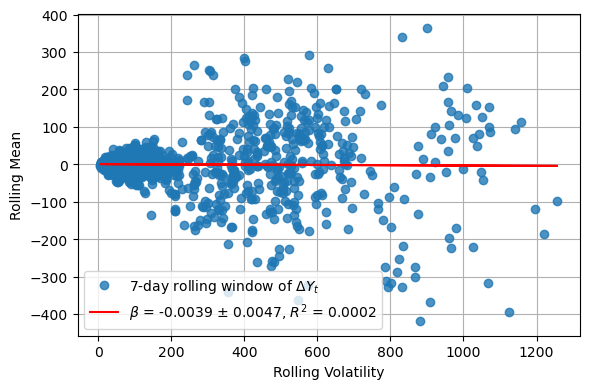

In [50]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

rolling_window = 7

# Function to calculate standard error of the slope
def compute_slope_std_err(x, y, slope, intercept):
    residuals = y - (slope * x + intercept)
    residual_sum_of_squares = np.sum(residuals ** 2)
    n = len(x)
    x_mean = np.mean(x)
    std_err_slope = np.sqrt(residual_sum_of_squares / (n - 2)) / np.sqrt(np.sum((x - x_mean) ** 2))
    return std_err_slope

## Plot 1 ##
plt.figure(figsize=(6, 4))

rolling_mean = Y_series.rolling(window=rolling_window).mean()
rolling_volatility = Y_series.rolling(window=rolling_window).std()
valid_indices = ~np.isnan(rolling_mean) & ~np.isnan(rolling_volatility)
rolling_mean = rolling_mean[valid_indices]
rolling_volatility = rolling_volatility[valid_indices]

coefficients = np.polyfit(rolling_volatility, rolling_mean, 1)
slope, intercept = coefficients
linear_fit = np.poly1d(coefficients)
predicted_mean = linear_fit(rolling_volatility)
r2 = r2_score(rolling_mean, predicted_mean)

std_err_slope = compute_slope_std_err(rolling_volatility, rolling_mean, slope, intercept)

plt.plot(rolling_volatility, rolling_mean, 'o', alpha=0.8, label=rf'{rolling_window}-day rolling window of $Y_t$')
plt.plot(rolling_volatility, predicted_mean, 'r-', 
         label=rf'$\beta$ = {slope:.4f} ± {std_err_slope:.4f}, $R^2$ = {r2:.4f}')
plt.xlabel('Rolling Volatility')
plt.ylabel('Rolling Mean')
#plt.title(f'Volatility-Conditional Mean of $Y_t$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Plot 2 ##
plt.figure(figsize=(6, 4))

rolling_mean_diff = Y_diff_series.rolling(window=rolling_window).mean()
rolling_volatility_diff = Y_diff_series.rolling(window=rolling_window).std()
valid_indices = ~np.isnan(rolling_mean_diff) & ~np.isnan(rolling_volatility_diff)
rolling_mean_diff = rolling_mean_diff[valid_indices]
rolling_volatility_diff = rolling_volatility_diff[valid_indices]

coefficients = np.polyfit(rolling_volatility_diff, rolling_mean_diff, 1)
slope, intercept = coefficients
linear_fit = np.poly1d(coefficients)
predicted_mean_diff = linear_fit(rolling_volatility_diff)
r2 = r2_score(rolling_mean_diff, predicted_mean_diff)

std_err_slope_diff = compute_slope_std_err(rolling_volatility_diff, rolling_mean_diff, slope, intercept)

plt.plot(rolling_volatility_diff, rolling_mean_diff, 'o', alpha=0.8, label=rf'{rolling_window}-day rolling window of $\Delta Y_t$')
plt.plot(rolling_volatility_diff, predicted_mean_diff, 'r-', 
         label=rf'$\beta$ = {slope:.4f} ± {std_err_slope_diff:.4f}, $R^2$ = {r2:.4f}')
plt.xlabel('Rolling Volatility')
plt.ylabel('Rolling Mean')
#plt.title(f'Volatility-Conditional Mean of $\Delta Y_t$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Spikes and Fat Tails

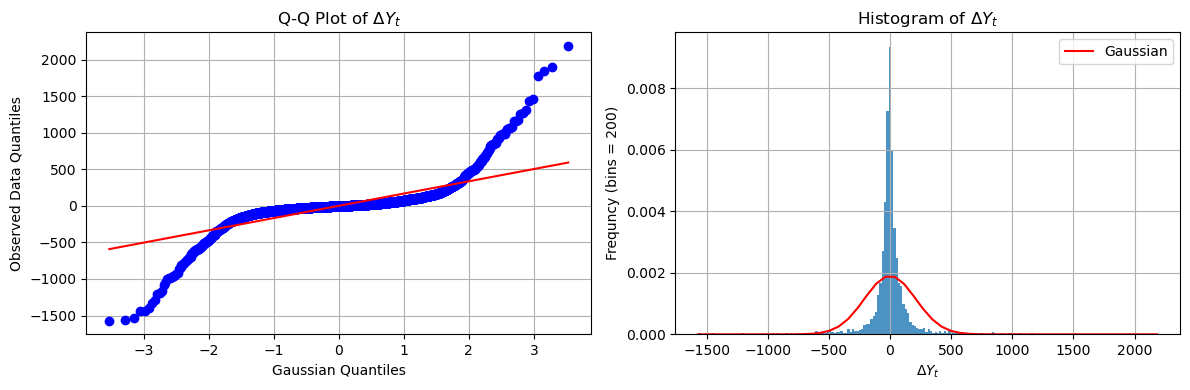

In [51]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# QQ Plot for Y_diff
probplot(Y_diff.flatten(), dist = norm, plot=axes[0])
axes[0].set_title(rf'Q-Q Plot of $\Delta Y_t$')
axes[0].set_ylabel('Observed Data Quantiles')
axes[0].set_xlabel('Gaussian Quantiles')
axes[0].grid(True)
axes[0].get_lines()[0].set_color('blue') 
axes[0].get_lines()[0].set_alpha(1)
plt.grid()

# Histogram for Y_diff
n_bins = 200
mean_Y_diff = np.mean(Y_diff)
std_Y_diff = np.std(Y_diff)
x = np.linspace(min(Y_diff), max(Y_diff))
gaussian_curve = norm.pdf(x, mean_Y_diff, std_Y_diff)

axes[1].hist(Y_diff, bins=n_bins, density=True, alpha=0.8)
axes[1].plot(x, gaussian_curve, 'r-', label='Gaussian')
axes[1].set_title(rf'Histogram of $\Delta Y_t$')
axes[1].set_xlabel('$\Delta Y_t$')
axes[1].set_ylabel(rf'Frequncy (bins = {n_bins})')
axes[1].grid(True) 
axes[1].legend()

plt.tight_layout()
plt.show()

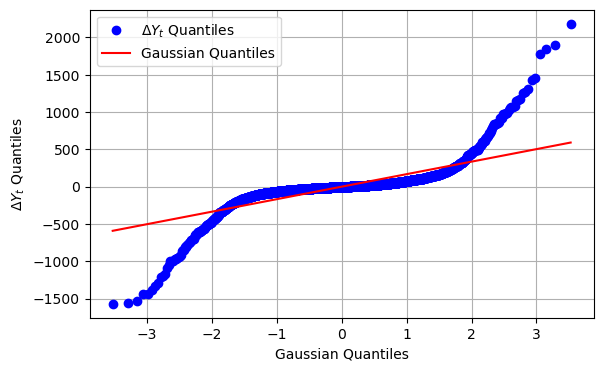

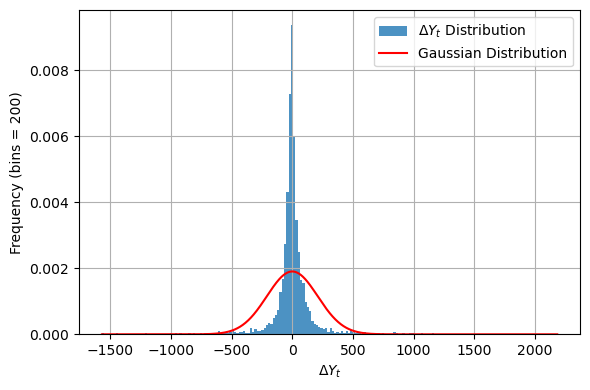

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot, norm
import scipy.stats as stats


#Y_diff = Y
# Parameters
n_bins = 200
mean_Y_diff = np.mean(Y_diff)
std_Y_diff = np.std(Y_diff)

## Plot 1: Q-Q Plot ##
fig, ax = plt.subplots(figsize=(6.5, 4))

# Generate QQ plot explicitly on the axis
stats.probplot(Y_diff, dist="norm", plot=ax)

# Remove default title added by probplot
ax.set_title("")

# Add custom labels and legend
ax.set_xlabel("Gaussian Quantiles")
ax.set_ylabel("$\Delta Y_t$ Quantiles")
ax.legend(["$\Delta Y_t$ Quantiles", "Gaussian Quantiles"], loc="best")

# Add grid and show the plot
ax.grid()
plt.show()


## Plot 2: Histogram ##
plt.figure(figsize=(6, 4))
x = np.linspace(min(Y_diff), max(Y_diff), 1000)
gaussian_curve = norm.pdf(x, mean_Y_diff, std_Y_diff)

plt.hist(Y_diff, bins=n_bins, density=True, alpha=0.8, label="$\Delta Y_t$ Distribution")
plt.plot(x, gaussian_curve, 'r-', label='Gaussian Distribution')
#plt.title(rf'Histogram of $\Delta Y_t$')
plt.xlabel(r'$\Delta Y_t$')
plt.ylabel(rf'Frequency (bins = {n_bins})')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

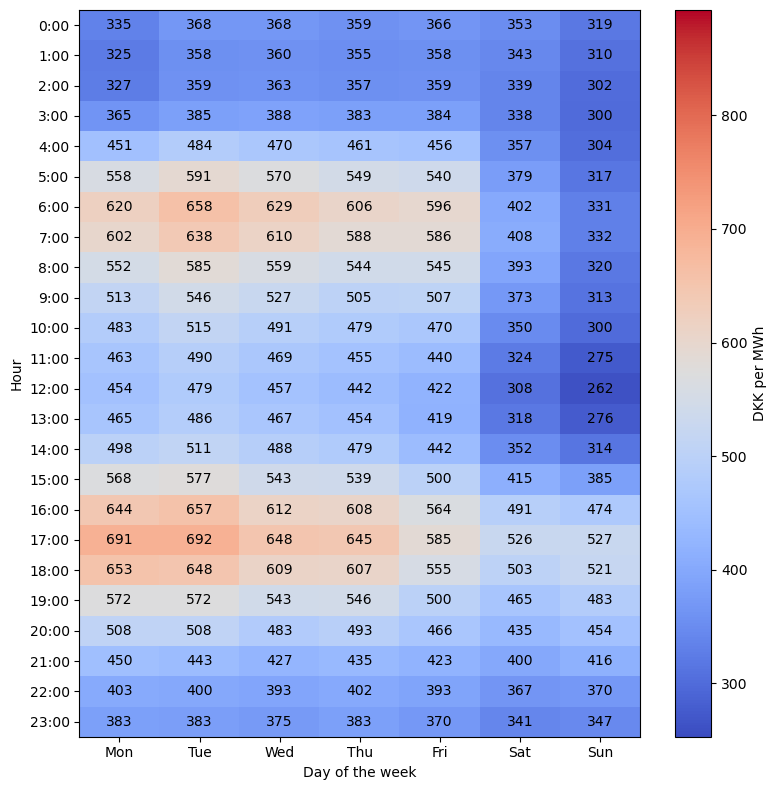

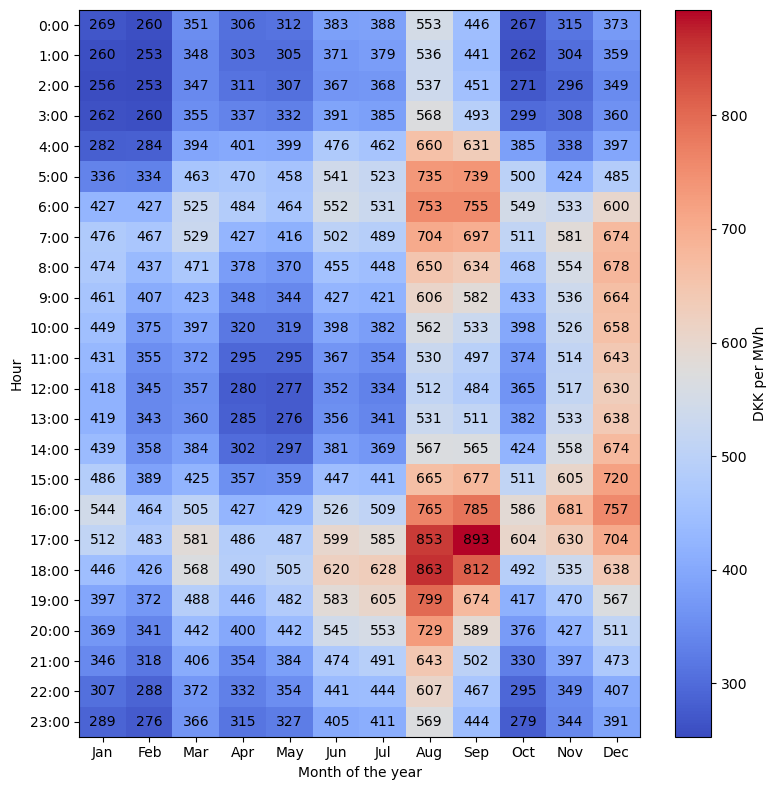

In [91]:
# Load data
data = pd.read_csv('../Data/non_nan_data.csv')

# Convert the DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract the hour of the day, day of the week, and month of the year
data['hour'] = data['DATE'].dt.hour
data['day_of_week'] = data['DATE'].dt.dayofweek  # Monday=0, Sunday=6
data['month'] = data['DATE'].dt.month

# Calculate the average spot price for DK2 by day of the week and hour
dk2_avg_day = data.groupby(['hour', 'day_of_week'])['DK2_spot'].mean().unstack()

# Calculate the average spot price for DK2 by month and hour
dk2_avg_month = data.groupby(['hour', 'month'])['DK2_spot'].mean().unstack()

# Calculate the global minimum and maximum values for consistent scaling
global_min = min(dk2_avg_day.min().min(), dk2_avg_month.min().min())
global_max = max(dk2_avg_day.max().max(), dk2_avg_month.max().max())

# ============================ First Plot ============================ #
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap for DK2 (hour of the day vs. day of the week)
cax1 = ax.imshow(dk2_avg_day, cmap='coolwarm', aspect='auto', interpolation='nearest', 
                 vmin=global_min, vmax=global_max)
#ax.set_title('Average Hourly Prices by Day of the Week')
ax.set_ylabel('Hour')
ax.set_xlabel('Day of the week')
ax.set_xticks(np.arange(7))  # Days of the week
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_yticks(np.arange(24))  # Hours of the day
ax.set_yticklabels([f'{i}:00' for i in range(24)])

# Annotate the heatmap
for i in range(24):
    for j in range(7):
        ax.text(j, i, f'{dk2_avg_day.iloc[i, j]:,.0f}', ha='center', va='center', color='black')

# Add colorbar
fig.colorbar(cax1, ax=ax, orientation='vertical', label='DKK per MWh')

# Show the first plot
plt.tight_layout()
plt.show()

# ============================ Second Plot ============================ #
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap for DK2 (hour of the day vs. month of the year)
cax2 = ax.imshow(dk2_avg_month, cmap='coolwarm', aspect='auto', interpolation='nearest', 
                 vmin=global_min, vmax=global_max)
#ax.set_title('Average Hourly Prices by Month of the Year')
ax.set_ylabel('Hour')
ax.set_xlabel('Month of the year')
ax.set_xticks(np.arange(12))  # Months of the year
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_yticks(np.arange(24))  # Hours of the day
ax.set_yticklabels([f'{i}:00' for i in range(24)])

# Annotate the heatmap
for i in range(24):
    for j in range(12):
        ax.text(j, i, f'{dk2_avg_month.iloc[i, j]:,.0f}', ha='center', va='center', color='black')

# Add colorbar
fig.colorbar(cax2, ax=ax, orientation='vertical', label='DKK per MWh')

# Show the second plot
plt.tight_layout()
plt.show()
